In [1]:
# !pip install -U "langchain-core>=0.2,<0.3" "langchain-openai>=0.1,<0.2" openai ragas
!pip install -U langgraph==1.0.1 langgraph-prebuilt==1.0.1 langchain-core langchain-openai openai ragas

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 155.4/155.4 kB 4.4 MB/s eta 0:00:00
  Using cached langgraph_prebuilt-1.0.1-py3-none-any.whl (28 kB)
  Using cached openai-2.11.0-py3-none-any.whl (1.1 MB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.5/66.5 kB 13.3 MB/s eta 0:00:00


  Using cached langchain-1.1.2-py3-none-any.whl (102 kB)
  Using cached langchain-1.1.1-py3-none-any.whl (102 kB)
  Using cached langchain-1.1.0-py3-none-any.whl (101 kB)
  Using cached langchain-1.0.8-py3-none-any.whl (93 kB)
  Using cached langchain-1.0.7-py3-none-any.whl (93 kB)
  Using cached langchain-1.0.6-py3-none-any.whl (93 kB)
  Using cached langchain-1.0.5-py3-none-any.whl (93 kB)
  Using cached langchain-1.0.4-py3-none-any.whl (93 kB)
  Using cached langchain-1.0.3-py3-none-any.whl (91 kB)
  Using cached langchain-1.0.2-py3-none-any.whl (107 kB)
  Attempting uninstall: langgraph-sdk
    Found existing installation: langgraph-sdk 0.3.0
    Uninstalling langgraph-sdk-0.3.0:
      Successfully uninstalled langgraph-sdk-0.3.0
  Attempting uninstall: langgraph-prebuilt
    Found existing installation: langgraph-prebuilt 1.0.0
    Uninstalling langgraph-prebuilt-1.0.0:
      Successfully uninstalled langgraph-prebuilt-1.0.0
  Attempting uninstall: langgraph
    Found existing ins

In [2]:
!pip install pysqlite3-binary
__import__('pysqlite3')
import sys
sys.modules['sqlite3'] = sys.modules.pop('pysqlite3')
!pip install chromadb
!pip install langchain-chroma


[notice] A new release of pip is available: 23.0.1 -> 25.3
[notice] To update, run: pip install --upgrade pip



[notice] A new release of pip is available: 23.0.1 -> 25.3
[notice] To update, run: pip install --upgrade pip



[notice] A new release of pip is available: 23.0.1 -> 25.3
[notice] To update, run: pip install --upgrade pip


In [3]:
!pip list

Package                                  Version
---------------------------------------- --------------
aiohappyeyeballs                         2.4.6
aiohttp                                  3.11.12
aiosignal                                1.3.2
annotated-types                          0.7.0
anyio                                    4.8.0
appdirs                                  1.4.4
argon2-cffi                              23.1.0
argon2-cffi-bindings                     21.2.0
arrow                                    1.3.0
asttokens                                3.0.0
async-timeout                            4.0.3
attrs                                    25.1.0
backoff                                  2.2.1
bcrypt                                   5.0.0
beautifulsoup4                           4.13.3
bleach                                   6.2.0
build                                    1.3.0
cachetools                               6.2.3
certifi                                  20


[notice] A new release of pip is available: 23.0.1 -> 25.3
[notice] To update, run: pip install --upgrade pip


In [4]:
from langchain_core.tools import tool
from langchain_core.messages import HumanMessage, AIMessage
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langchain_chroma import Chroma
from langchain_core.documents import Document
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langgraph.graph import START, END, StateGraph
from langgraph.graph.message import MessagesState
from langgraph.prebuilt import ToolNode
from IPython.display import Image, display
from dotenv import load_dotenv
from ragas import EvaluationDataset
from ragas import evaluate
from ragas.llms import LangchainLLMWrapper
from ragas.metrics import LLMContextRecall, Faithfulness, FactualCorrectness
from ragas import messages as ragas_messages
from ragas.integrations.langgraph import convert_to_ragas_messages
from ragas.dataset_schema import MultiTurnSample
from ragas.metrics import ToolCallAccuracy
from ragas.metrics import AgentGoalAccuracyWithReference

/opt/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
OPENAI_API_KEY="voc-*"

In [6]:
load_dotenv()

False

**Simple RAG**

In [7]:
documents = [
    Document(
        page_content="Meta drops multimodal Llama 3.2 — here's why it's such a big deal",
        metadata={"company":"Meta", "topic": "llama"}
    ),
    Document(
        page_content="Chip giant Nvidia acquires OctoAI, a Seattle startup that helps companies run AI models",
        metadata={"company":"Nvidia", "topic": "acquisition"}
    ),
    Document(
        page_content="Google is bringing Gemini to all older Pixel Buds",
        metadata={"company":"Google", "topic": "gemini"}
    ),
    Document(
        page_content="The first Intel Battlmage GPU benchmarks have leaked",
        metadata={"company":"Intel", "topic": "gpu"}
    ),
    Document(
        page_content="Dell partners with Nvidia to accelerate AI adoption in telecoms",
        metadata={"company":"Dell", "topic": "partnership"}
    ),
]

ids = ["id1", "id2", "id3", "id4", "id5"]

In [8]:
vector_store = Chroma(
    collection_name="udacity",
    embedding_function=OpenAIEmbeddings(
    api_key=OPENAI_API_KEY,
    ),
)

vector_store.add_documents(documents=documents, ids=ids)
retriever = vector_store.as_retriever(search_kwargs={"k": 1})

In [9]:
llm = ChatOpenAI(
    model="gpt-4o-mini",
    temperature=0.0,
    api_key=OPENAI_API_KEY,
)

In [10]:
prompt = ChatPromptTemplate.from_template(
    """Answer the question based only on the following context:
    {context}

    Question: {query}
    """
)

chain = prompt | llm | StrOutputParser()

In [11]:
def format_docs(relevant_docs):
    return "\n".join(doc.page_content for doc in relevant_docs)

In [12]:
query = "Who is partnering with Nvidia?"
relevant_docs = retriever.invoke(query)
chain.invoke({"context": format_docs(relevant_docs), "query": query})

'Dell is partnering with Nvidia.'

**Ragas Evaluation**

In [13]:
sample_queries = [
    "What is Meta's latest development in AI?",
    "Which company did Nvidia acquire?",
    "What AI feature is Google adding to older Pixel Buds?",
    "What recent information has leaked about Intel GPUs?",
    "Which company did Dell partner with to accelerate AI adoption?"
]

In [14]:
expected_responses = [
    "Meta drops multimodal Llama 3.2 — here's why it's such a big deal",
    "Chip giant Nvidia acquires OctoAI, a Seattle startup that helps companies run AI models",
    "Google is bringing Gemini to all older Pixel Buds",
    "The first Intel Battlemage GPU benchmarks have leaked",
    "Dell partners with Nvidia to accelerate AI adoption in telecoms"
]

In [15]:
dataset = []

for query, reference in zip(sample_queries, expected_responses):
    relevant_docs = retriever.invoke(query)
    response = chain.invoke(
        {
            "context": format_docs(relevant_docs), 
            "query": query
        }
    )
    dataset.append(
        {
            "user_input": query,
            "retrieved_contexts": [doc.page_content for doc in relevant_docs],
            "response": response,
            "reference": reference,
        }
    )

evaluation_dataset = EvaluationDataset.from_list(dataset)

In [16]:
evaluator_llm = LangchainLLMWrapper(llm)

result = evaluate(
    dataset=evaluation_dataset,
    metrics=[LLMContextRecall(), Faithfulness(), FactualCorrectness()],
    llm=evaluator_llm,
)

/tmp/ipykernel_585/298900310.py:1: DeprecationWarning: LangchainLLMWrapper is deprecated and will be removed in a future version. Use llm_factory instead: from openai import OpenAI; from ragas.llms import llm_factory; llm = llm_factory('gpt-4o-mini', client=OpenAI(api_key='...'))
  evaluator_llm = LangchainLLMWrapper(llm)
Evaluating: 100%|██████████| 15/15 [00:08<00:00,  1.84it/s]


In [17]:
result

{'context_recall': 1.0000, 'faithfulness': 1.0000, 'factual_correctness(mode=f1)': 0.5400}

**LangGraph workflow**

In [18]:
pokemon_types_map = {
    "pikachu": "electric",
    "eevee": "normal",
    "bulbasaur": "grass/poison",
    "squirtle": "water",
    "charizard": "fire/flying",
    "jigglypuff": "normal/fairy",
    "meowth": "normal",
    "psyduck": "water",
    "machamp": "fighting",
    "gengar": "ghost/poison",
    "alakazam": "psychic",
    "snorlax": "normal",
    "dragonite": "dragon/flying",
}

In [19]:
@tool
def get_pokemon_type(pokemon_name: str) -> str:
    """Fetches the type of the specified Pokémon.

    Args:
        pokemon_name : The name of the Pokémon (e.g., 'pikachu', 'charizard', 'eevee').

    Returns:
        str: The type(s) of the Pokémon.

    Raises:
        KeyError: If the specified Pokémon is not found in the data source.
    """
    try:
        pokemon_name = pokemon_name.lower().strip()
        if pokemon_name not in pokemon_types_map:
            raise KeyError(
                f"Pokémon '{pokemon_name}' not found. Available Pokémon: {', '.join(pokemon_types.keys())}"
            )
        return pokemon_types_map[pokemon_name]
    except Exception as e:
        raise Exception(f"Error fetching Pokémon type: {str(e)}")

In [20]:
tools = [get_pokemon_type]

In [21]:
llm_with_tools = llm.bind_tools(tools)

In [22]:
def agent(state: MessagesState):
    ai_message = llm_with_tools.invoke(state["messages"])
    return {"messages": ai_message}

In [23]:
def router(state: MessagesState):
    last_message = state["messages"][-1]
    if last_message.tool_calls:
        return "tools"

    return END

In [24]:
workflow = StateGraph(MessagesState)

workflow.add_node("agent", agent)
workflow.add_node("tools", ToolNode(tools))

workflow.add_edge(START, "agent")

workflow.add_conditional_edges(
    source="agent", 
    path=router, 
    path_map=["tools", END]
)

workflow.add_edge("tools", "agent")


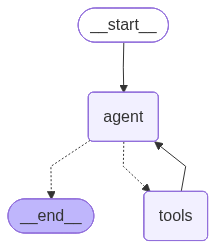

In [25]:
graph = workflow.compile()

display(
    Image(
        graph.get_graph().draw_mermaid_png()
    )
)

In [26]:
result = graph.invoke(
    {"messages": [HumanMessage(content="What is the Gengar's type?")]}
)

In [27]:
for message in result["messages"]:
    message.pretty_print()

================================ Human Message =================================

What is the Gengar's type?
================================== Ai Message ==================================
Tool Calls:
  get_pokemon_type (call_wFYljluarDychoVnPiAzvpnq)
 Call ID: call_wFYljluarDychoVnPiAzvpnq
  Args:
    pokemon_name: gengar
================================= Tool Message =================================
Name: get_pokemon_type

ghost/poison
================================== Ai Message ==================================

Gengar is a Ghost/Poison type Pokémon.


**Converting to Ragas**

In [28]:
ragas_trace = convert_to_ragas_messages(result["messages"])

In [29]:
ragas_trace

[HumanMessage(content="What is the Gengar's type?", metadata=None, type='human'),
 AIMessage(content='', metadata=None, type='ai', tool_calls=[]),
 ToolMessage(content='ghost/poison', metadata=None, type='tool'),
 AIMessage(content='Gengar is a Ghost/Poison type Pokémon.', metadata=None, type='ai', tool_calls=[])]

In [34]:
ragas_messages.ToolCall(
    name="get_pokemon_type", 
    args={"pokemon_name": "gengar"}
)

ToolCall(name='get_pokemon_type', args={'pokemon_name': 'gengar'})

**Evaluate Tool Use**

In [36]:
sample = MultiTurnSample(
    user_input=ragas_trace,
    reference_tool_calls=[
        ragas_messages.ToolCall(
            name="get_pokemon_type", 
            args={"pokemon_name": "gengar"}
        )
    ],
)

ValidationError: 1 validation error for MultiTurnSample
user_input
  Value error, ToolMessage must follow an AIMessage where tools were called. [type=value_error, input_value=[HumanMessage(content="Wh...pe='ai', tool_calls=[])], input_type=list]
    For further information visit https://errors.pydantic.dev/2.10/v/value_error

In [31]:
scorer = ToolCallAccuracy()
scorer.llm = llm

In [32]:
await scorer.multi_turn_ascore(sample)

NameError: name 'sample' is not defined

**Evaluate Agent Goal**

In [33]:
sample = MultiTurnSample(
    user_input=ragas_trace,
    reference="What is the Gengar's type?",
)

ValidationError: 1 validation error for MultiTurnSample
user_input
  Value error, ToolMessage must follow an AIMessage where tools were called. [type=value_error, input_value=[HumanMessage(content="Wh...pe='ai', tool_calls=[])], input_type=list]
    For further information visit https://errors.pydantic.dev/2.10/v/value_error

In [ ]:
scorer = AgentGoalAccuracyWithReference()
scorer.llm = LangchainLLMWrapper(llm)

In [ ]:
await scorer.multi_turn_ascore(sample)